<a href="https://colab.research.google.com/github/yashobhan/GenAI-Training/blob/main/5-NewsClassification_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [1]:
!pip install textblob 'keras-nlp' 'keras-preprocessing' 'gensim==4.2.0' np_utils swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
  Created wheel for np_utils: 

In [24]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob

TRACE = False
embedding_dim = 300
epochs=100
batch_size = 250
corpus_size=25000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config)
  tf.compat.v1.keras.backend.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%%writefile get_data.sh
if [ ! -f news.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

Writing get_data.sh


In [4]:
!bash get_data.sh

--2023-11-21 12:29:04--  https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/352x7xzivf60zgc/news.csv [following]
--2023-11-21 12:29:05--  https://www.dropbox.com/s/raw/352x7xzivf60zgc/news.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9882535d6c40b4853933898dc2.dl.dropboxusercontent.com/cd/0/inline/CH8Hcb0tQ8dAgKmi080ZIxmnAlwsoIkeymW8GyqxfCmxKF_xxxXeGtVFYfO5LvUgUP32VaY2BXvnjc7H4CUcNvpDyfeXd1sB795HzfzvX_sacx6LaV5wMI8U8LGMlf3NtvZDiQg8CczCL53Jo1AqA9wk/file# [following]
--2023-11-21 12:29:05--  https://uc9882535d6c40b4853933898dc2.dl.dropboxusercontent.com/cd/0/inline/CH8Hcb0tQ8dAgKmi080ZIxmnAlwsoIkeymW8GyqxfCmxKF_xxxXeGtVFYfO5LvUgUP32VaY2BXvnjc7H4CUcNvpDyfeXd1sB795HzfzvX_

In [5]:
path = './news.csv'
news_pre = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)

In [10]:
news_pre.head()

,category,title
0,Business,"BBC set for major shake-up, claims newspaper"
1,Business,Marsh averts cash crunch
2,Sports,"Jeter, Yankees Look to Take Control (AP)"
3,Sci/Tech,Flying the Sun to Safety
4,Business,Stocks Seen Flat as Nortel and Oil Weigh


In [22]:
import string

def preprocess_text(text, should_join=True):
    # Use the tokenizer to tokenize into words, lowercase them, remove punctuation, and finally use gensim.utils.simple_preprocess(text)
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [23]:
preprocess_text("This is great!")

'this is great'

In [27]:
import swifter
# Use swifter to apply the preprocessin and save that pandas series to a file
news = news_pre["title"].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

In [31]:

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, preprocessed_corpus):
      self.preprocessed_corpus = preprocessed_corpus

    def __iter__(self):
        for line in self.preprocessed_corpus:
            # assume there's one document per line, tokens separated by whitespace
            yield preprocess_text(line, should_join=False)


word2vec_model = gensim.models.Word2Vec(sentences=MyCorpus(news))
# Get a word2vec model using gensim.models and passing the sentences using MyCorpus()

In [53]:
weights = word2vec_model.wv.vectors  # Get the weights of the model (the embedding) and convert to tensor. Hint: Check word2vec_model.wv
vocab_size = len(word2vec_model.wv.index_to_key) + 1  # get vocab size from index_to_key in word2vec_model.wv

In [54]:
weights.shape

(4917, 100)

In [55]:
vocab_size

4918

In [56]:
news_preprocessed = pd.DataFrame()
news_preprocessed['label'] = news_pre.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})
news_preprocessed['title'] = news
news_preprocessed

,label,title
0,0,bbc set for major shakeup claims newspaper
1,0,marsh averts cash crunch
2,1,jeter yankees look to take control ap
3,2,flying the sun to safety
4,0,stocks seen flat as nortel and oil weigh
...,...,...
24995,0,walmart clarifies policy regarding unions ap
24996,2,viewpoint better russian planning would preven...
24997,1,no syracuse princeton
24998,1,usc oklahoma still auburn third in bcs


In [80]:
def get_maximum_review_length(df):
    # maximum = 0
    # for ix, row in df.iterrows():
    #     candidate = len(textblob_tokenizer(row.title))
    #     if candidate > maximum:
    #         maximum = candidate
    # return maximum
    return df.title.str.split().apply(len).max()


maximum = get_maximum_review_length(news_preprocessed)   # Since 2 titles may have different number of words, we have to find the max length and fill with 0s if a title is shorter

In [81]:
maximum

17

In [82]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_preprocessed.title.tolist())

In [116]:
# X = np.zeros((len(news_preprocessed), maximum))   # Here we do what we said above
# Iterate through the news df and for every word, if it exists in the word2vec model, put into X for that review and that word the index of the embedding (check index_to_key)
# HINT: to iterate through a column of a pandas dataframe you do:

# for index, value in df.iterrows():
#      #do something

# for index, value in news_preprocessed.iterrows():
#   print(index, value)

# for title in news_preprocessed["title"].tolist():
#   for word in title.split():
#     if word in word2vec_model.wv.index_to_key:
#       X[]



# for word, idx in word2vec_model.wv.key_to_index.items():
#   if word in tokenizer.word_index:
#     X[idx, :] = word2vec_model.wv.vectors[idx][:maximum]

# FILL
y = news_preprocessed.label




X = np.zeros((len(news_preprocessed), maximum))   # Here we do what we said above
# Iterate through the news df and for every word, if it exists in the word2vec model, put into X for that review and that word the index of the embedding (check index_to_key)
# HINT: to iterate through a column of a pandas dataframe you do:

# for index, value in df.iterrows():
#      #do something

found = 0
not_found = 0

for ind, row in news_preprocessed.iterrows():
  words = textblob_tokenizer(row.title)
  for i, word in enumerate(words):
    if word in word2vec_model.wv.key_to_index:
      found += 1
      X[ind, i] = word2vec_model.wv.key_to_index[word]
    else:
      not_found += 1

# FILL
y = news_preprocessed.label

In [117]:
X.shape

(25000, 17)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
# Convert y_train and y_test from an array of values between 0-3 to a one hot matrix tensor
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [123]:
model = Sequential()
model.add(Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1],
                    embeddings_initializer=tf.keras.initializers.Constant(weights), trainable=False))  # Add an Embedding layer with weights being the rweights variable and trainable as False. The embedding dimension should be embedding_dim
model.add(Dense(64, activation="relu"))  # Add a couple of Dense Layers with RELU or leaky_relu activations. You may add Batch Norm if you want too
# model.add(BatchNormalization())
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(None, embedding_dim,)))  # Average out the words of the sentence. The expected out is (N, D) where N is number f samples in batch and D is embedding dimension
model.add(Dense(y_train.shape[1], activation="softmax"))  # Add final Dense layer

In [124]:
# Compile the model. Think what is the best loss to use
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam())
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         491700    
                                                                 
 dense_10 (Dense)            (None, None, 64)          6464      
                                                                 
 lambda_5 (Lambda)           (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 498424 (1.90 MB)
Trainable params: 6724 (26.27 KB)
Non-trainable params: 491700 (1.88 MB)
_________________________________________________________________


In [125]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, min_delta=0.01)
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), callbacks=[callback], epochs=50, batch_size=64) # Fit the model, use the callback above to do EarlyStopping

Epoch 1/50
313/313 [==============================] - 2s 3ms/step - loss: 1.3848 - val_loss: 1.3827
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 1.3678 - val_loss: 1.3623
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 1.3482 - val_loss: 1.3457
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 1.3339 - val_loss: 1.3341
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3265 - val_loss: 1.3353
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3196 - val_loss: 1.3229
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3166 - val_loss: 1.3180
Epoch 8/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3116 - val_loss: 1.3142
Epoch 9/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3059 - val_loss: 1.3087
Epoch 10/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3006 - val_loss: 1.3011

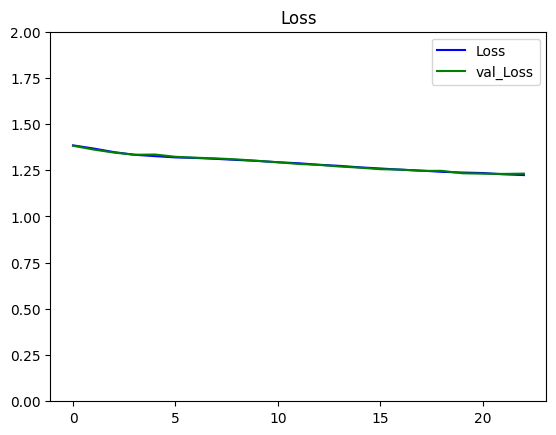

In [126]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)


In [127]:
# Test with the following two sentences:
# - 'supercomputer will put workers jobless soon'
# - 'patriots goes winning super bowl'

test_data = ['supercomputer will put workers jobless soon', 'patriots goes winning super bowl']

x_val = np.zeros((len(test_data), maximum))   # Here we do what we said above

for ind, text in enumerate(test_data):
  words = textblob_tokenizer(text)
  for i, word in enumerate(words):
    if word in word2vec_model.wv.key_to_index:
      x_val[ind, i] = word2vec_model.wv.key_to_index[word]

y_val = model.predict(x_val)
print(y_val)

1/1 [==============================] - 0s 106ms/step
[[0.31889927 0.22244108 0.30025366 0.15840593]
 [0.2371856  0.2968449  0.30627197 0.15969752]]


In [133]:
index = tf.argmax(y_val, axis=-1)
index

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 2])>

In [ ]:
{'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3}